# Maximum Sharpe ratio portfolio on selected Danish stocks

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from port_opt import get_portf_rtn, get_portf_vol, get_optimal_portfolio, get_efficient_frontier, neg_sharpe_ratio

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [5.5, 3]
plt.rcParams['figure.dpi'] = 200

np.random.seed(0)

## Preprocess and load the data

In [3]:
%run preprocessing.py -n DK -i stock

In [4]:
close_df = pd.read_csv('..\data\DK\preprocessed_data\danish_closed_stocks.csv', index_col=0)

In [5]:
# Constants
danish_2y_yield = 0.03463
stocks_names = close_df.columns.tolist()

dividends = {stock: 0 for stock in stocks_names}
dividends['ORSTED'] = 2.14 / 100
dividends['MAERSK'] = 27.53 / 100
dividends['VWS'] = 0.0
dividends['CHR'] = 1.63 / 100
dividends['NOVO'] = 1.32 / 100
dividends['NZYM'] = 1.71 / 100
dividends['DNORD'] = 10.77 / 100
dividends['TRMD'] = 16.52 / 100
dividends['STG'] = 6.76 / 100
dividends['SOLAR'] = 7.26 / 100
dividends['AOJ'] = 6.32 /100
dividends['SKAKO'] = 7.99 / 100
dividends['NDA'] = 8.04 / 100
dividends['LUXOR'] = 5.68 / 100
dividends['PNDORA'] = 3.28 / 100

dividends = pd.Series(dividends)

In [6]:
close_df.head()

,AOJ,CHR,DNORD,LUXOR,MAERSK,NDA,NOVO,NZYM,ORSTED,PNDORA,SKAKO,SOLAR,STG,TOP,TRMD,VWS,ZEAL
2016-06-09 09:00:00+02:00,17.419270,369.411660,64.130959,NaN,5045.532146,40.070159,321.379956,279.415738,226.444085,753.539715,46.989652,215.004439,68.773193,117.536641,48.681280,86.325277,123.5
2016-06-10 09:00:00+02:00,17.542520,361.352082,61.591762,NaN,4903.035849,38.644739,312.631414,273.018271,221.177944,725.844534,45.784789,209.540948,68.394625,113.846544,44.596138,83.535190,121.0
2016-06-13 09:00:00+02:00,17.534303,355.772390,59.508322,217.417489,4801.252780,38.232949,311.516413,272.657860,214.156422,713.150910,44.178305,203.113311,66.880353,111.318126,45.276995,81.842536,115.5
2016-06-14 09:00:00+02:00,17.534303,349.572722,58.434046,217.417489,4580.238116,37.282669,294.190878,267.521855,218.895940,698.149353,42.973443,199.256729,66.249406,108.858063,43.915281,79.926679,108.5
2016-06-15 09:00:00+02:00,17.534303,351.609747,59.573429,217.417489,4676.205009,37.852838,295.220125,272.207335,222.494479,712.381599,45.784789,200.863639,66.375595,109.951421,44.255709,80.428891,113.0


## EDA

In [7]:
returns_df = close_df.pct_change().dropna()
returns_df

,AOJ,CHR,DNORD,LUXOR,MAERSK,NDA,NOVO,NZYM,ORSTED,PNDORA,SKAKO,SOLAR,STG,TOP,TRMD,VWS,ZEAL
2016-06-14 09:00:00+02:00,0.000000e+00,-0.017426,-0.018053,0.000000,-0.046033,-0.024855,-0.055617,-0.018837,0.022131,-0.021036,-0.027273,-0.018987,-0.009434,-0.022099,-0.030075,-0.023409,-0.060606
2016-06-15 09:00:00+02:00,0.000000e+00,0.005827,0.019499,0.000000,0.020952,0.015293,0.003499,0.017514,0.016439,0.020386,0.065421,0.008065,0.001905,0.010044,0.007752,0.006283,0.041475
2016-06-16 09:00:00+02:00,0.000000e+00,0.015617,-0.026776,0.000000,-0.027363,-0.024268,-0.016851,-0.020192,-0.010651,-0.014579,-0.035088,-0.035200,-0.013308,-0.019888,-0.007692,-0.022895,-0.048673
2016-06-17 09:00:00+02:00,0.000000e+00,0.007688,0.037058,0.000000,0.017263,0.036021,-0.002660,0.003378,0.022727,0.010411,-0.018182,0.011609,0.021195,0.012682,0.007752,0.036213,0.004651
2016-06-20 09:00:00+02:00,-2.530459e-02,0.031996,0.017325,0.000000,0.013828,0.038079,0.010370,0.030976,0.007797,0.027115,0.037037,0.044262,0.021698,0.030683,0.000000,0.031064,0.060185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-24 09:00:00+02:00,6.250000e-03,-0.009116,0.015066,-0.007634,-0.004753,0.002592,-0.008294,-0.004793,0.017509,-0.001506,0.000000,0.002041,-0.005168,0.002584,0.027778,0.010356,-0.032446
2023-07-25 09:00:00+02:00,-2.484435e-03,0.020000,0.008040,0.046154,-0.002572,0.005042,-0.007091,0.017760,0.002922,-0.000603,0.006849,0.007128,0.005195,-0.001933,0.024453,0.013208,-0.033534
2023-07-26 09:00:00+02:00,2.490623e-03,0.000392,-0.007975,-0.022059,0.000737,-0.022511,-0.028566,-0.001775,0.003885,-0.015993,-0.013605,-0.008089,0.014643,-0.001937,-0.033292,-0.001251,-0.030249
2023-07-27 09:00:00+02:00,8.695615e-03,0.009016,0.004947,0.022556,0.018403,0.010001,0.003205,0.016000,-0.011287,0.026679,0.013793,0.019368,0.005942,0.004528,0.016894,-0.034666,0.010092


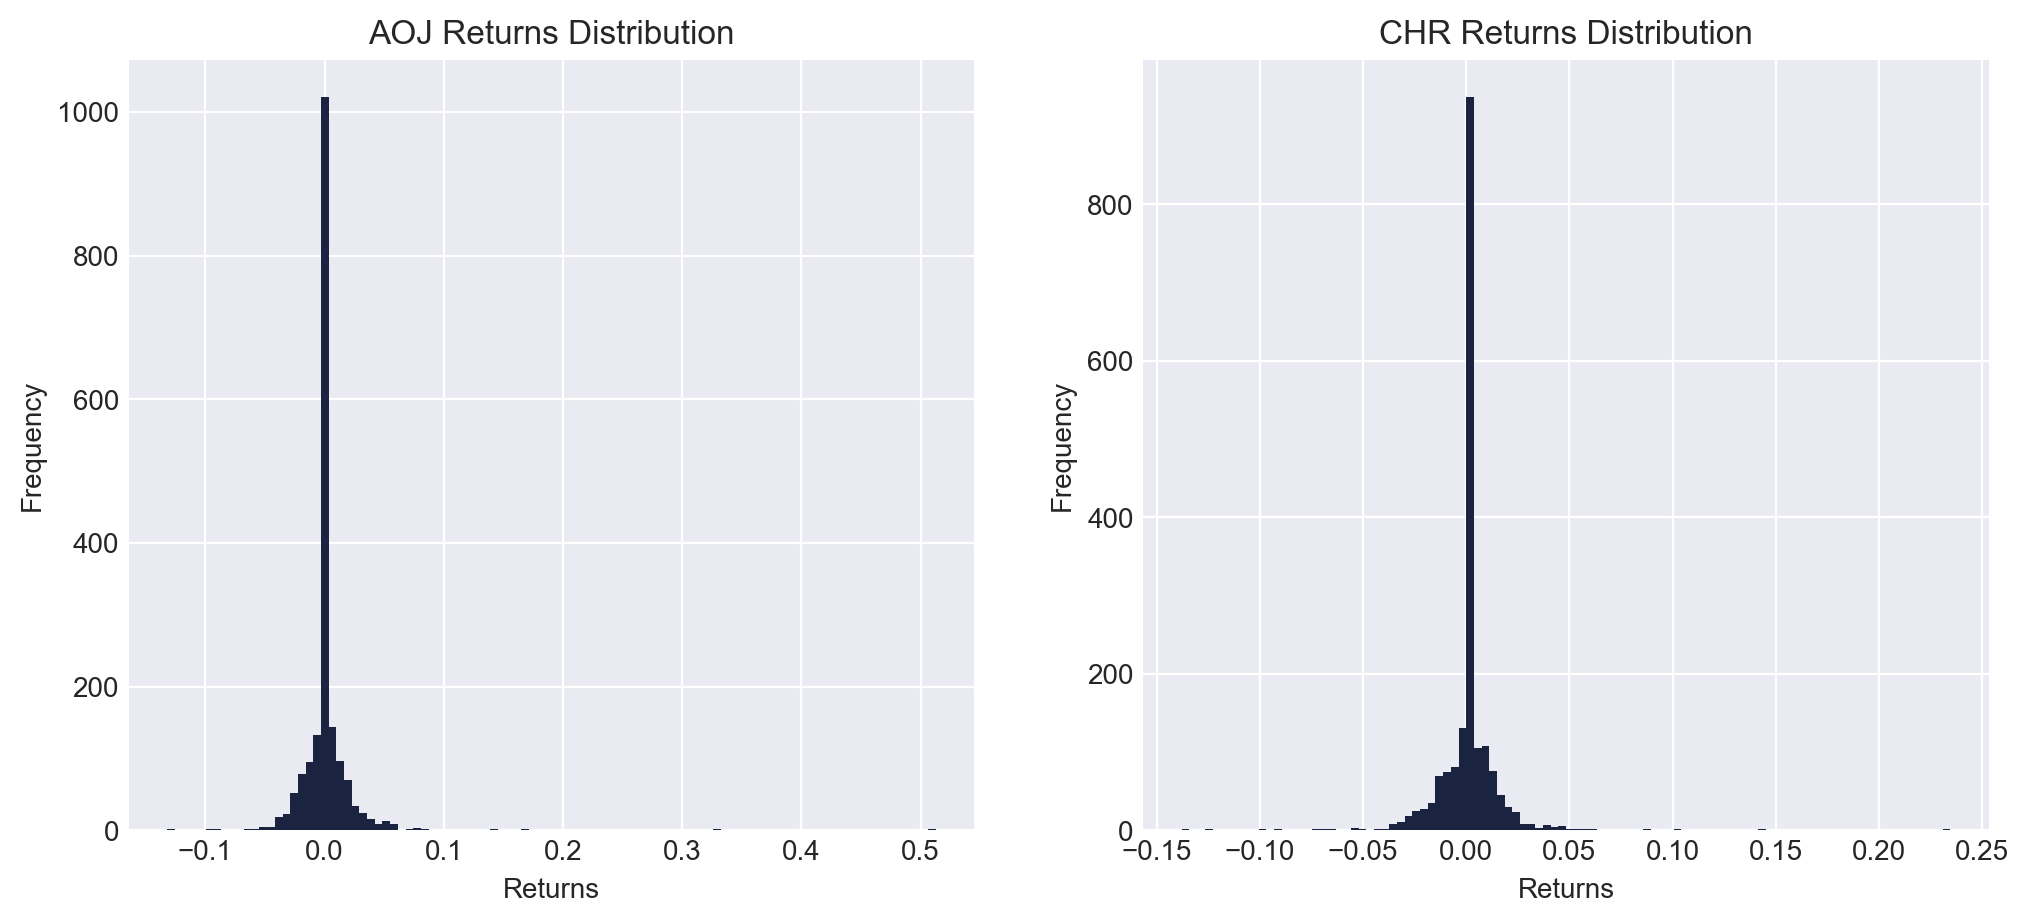

In [8]:
# Visuallize the returns distrubution of AOJ
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(returns_df.loc[:, 'AOJ'], bins=100)
axs[0].set(xlabel='Returns', ylabel='Frequency', title='AOJ Returns Distribution')

axs[1].hist(returns_df.loc[:, 'CHR'], bins=100)
axs[1].set(xlabel='Returns', ylabel='Frequency', title='CHR Returns Distribution')

plt.show()

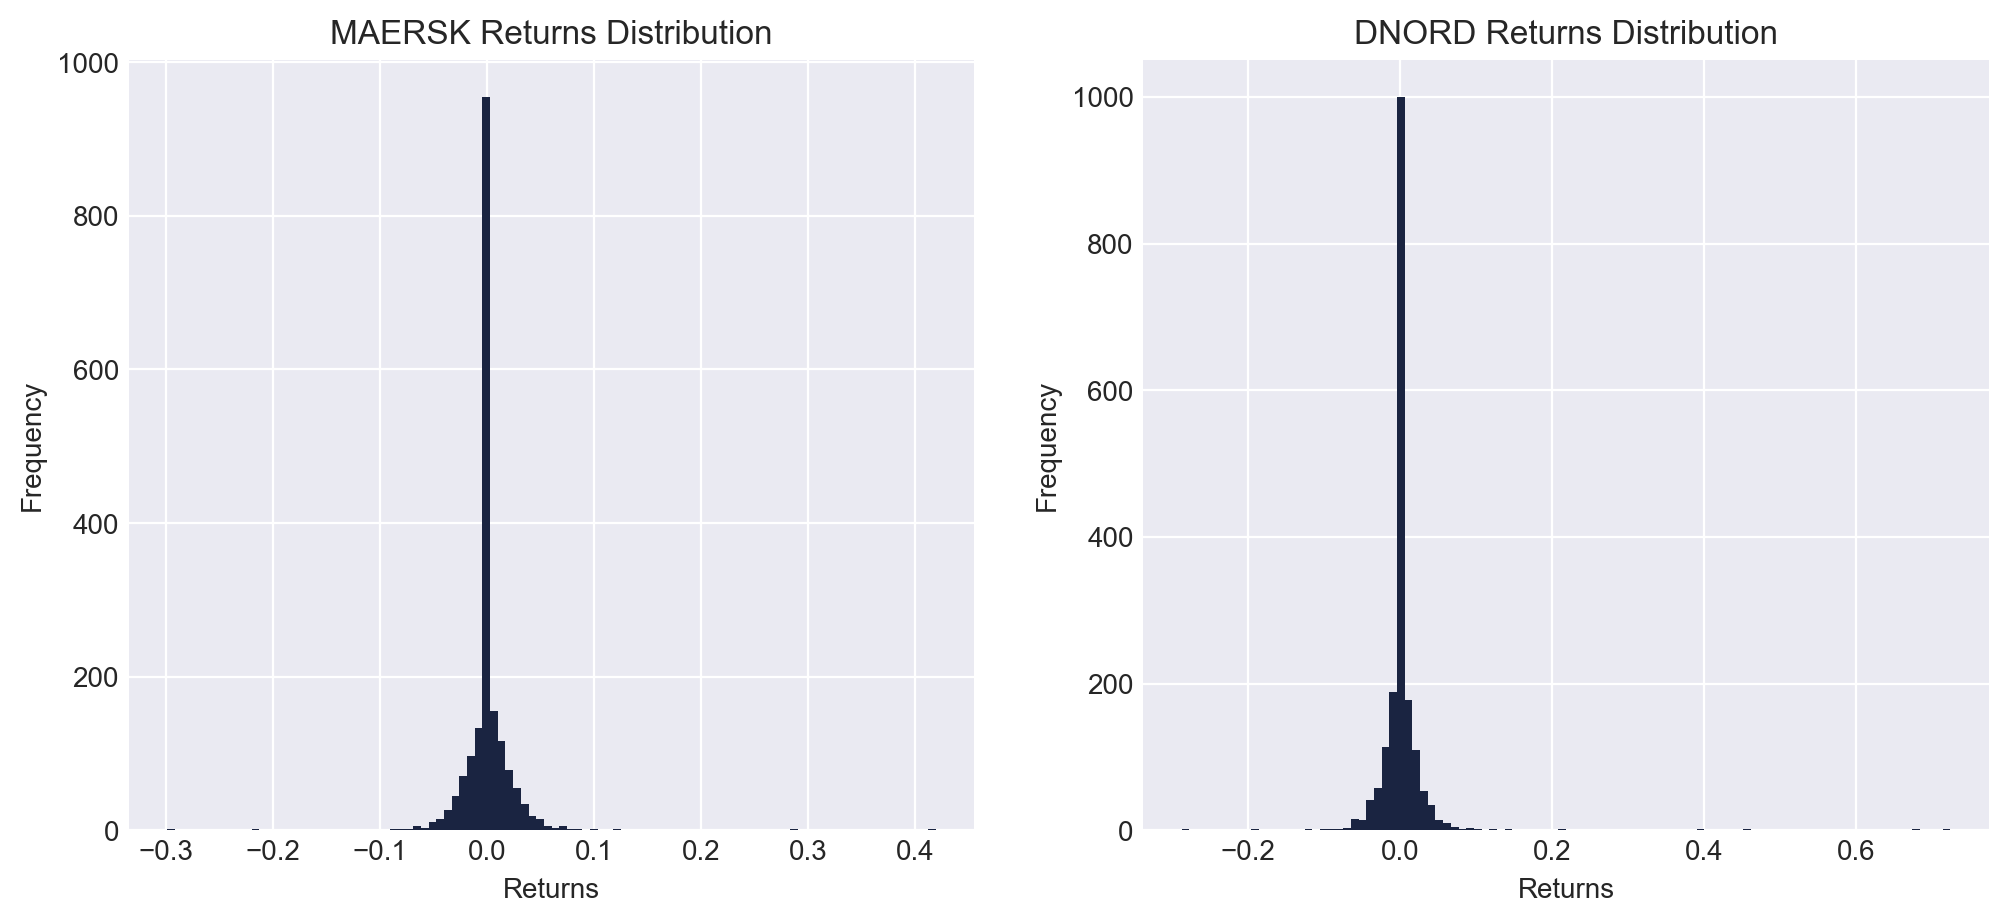

In [9]:
# Visuallize the returns distrubution of AOJ
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(returns_df.loc[:, 'MAERSK'], bins=100)
axs[0].set(xlabel='Returns', ylabel='Frequency', title='MAERSK Returns Distribution')

axs[1].hist(returns_df.loc[:, 'DNORD'], bins=100)
axs[1].set(xlabel='Returns', ylabel='Frequency', title='DNORD Returns Distribution')

plt.show()

### Correlation of the returns

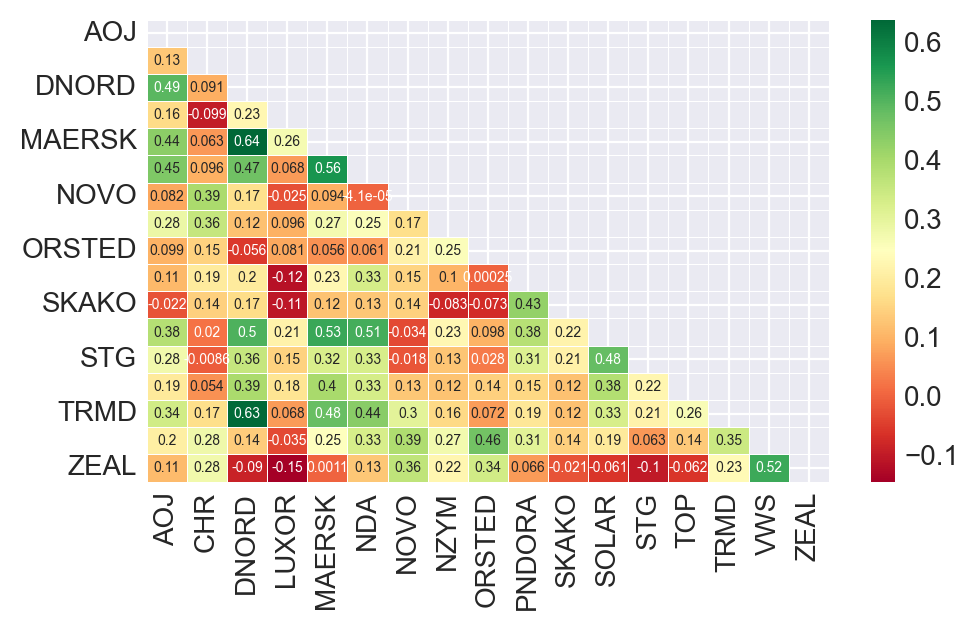

In [10]:
r_corr_matrix = returns_df.corr()

mask = np.zeros_like(r_corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(r_corr_matrix, annot=True, mask=mask, cmap='RdYlGn', linewidths=0.2, annot_kws={'size': 5});

## Portfolio optimization

In [11]:
n_days = 260
n_portfolios = 100_000
n_assets = len(stocks_names)
avg_returns = returns_df.mean() * n_days
avg_returns = avg_returns + dividends
cov_matrix = returns_df.cov() * n_days

In [12]:
np.random.seed(0)
weights = np.random.random(size=(n_portfolios, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [13]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_matrix, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = (portf_rtns - danish_2y_yield) / portf_vol

In [14]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [15]:
n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

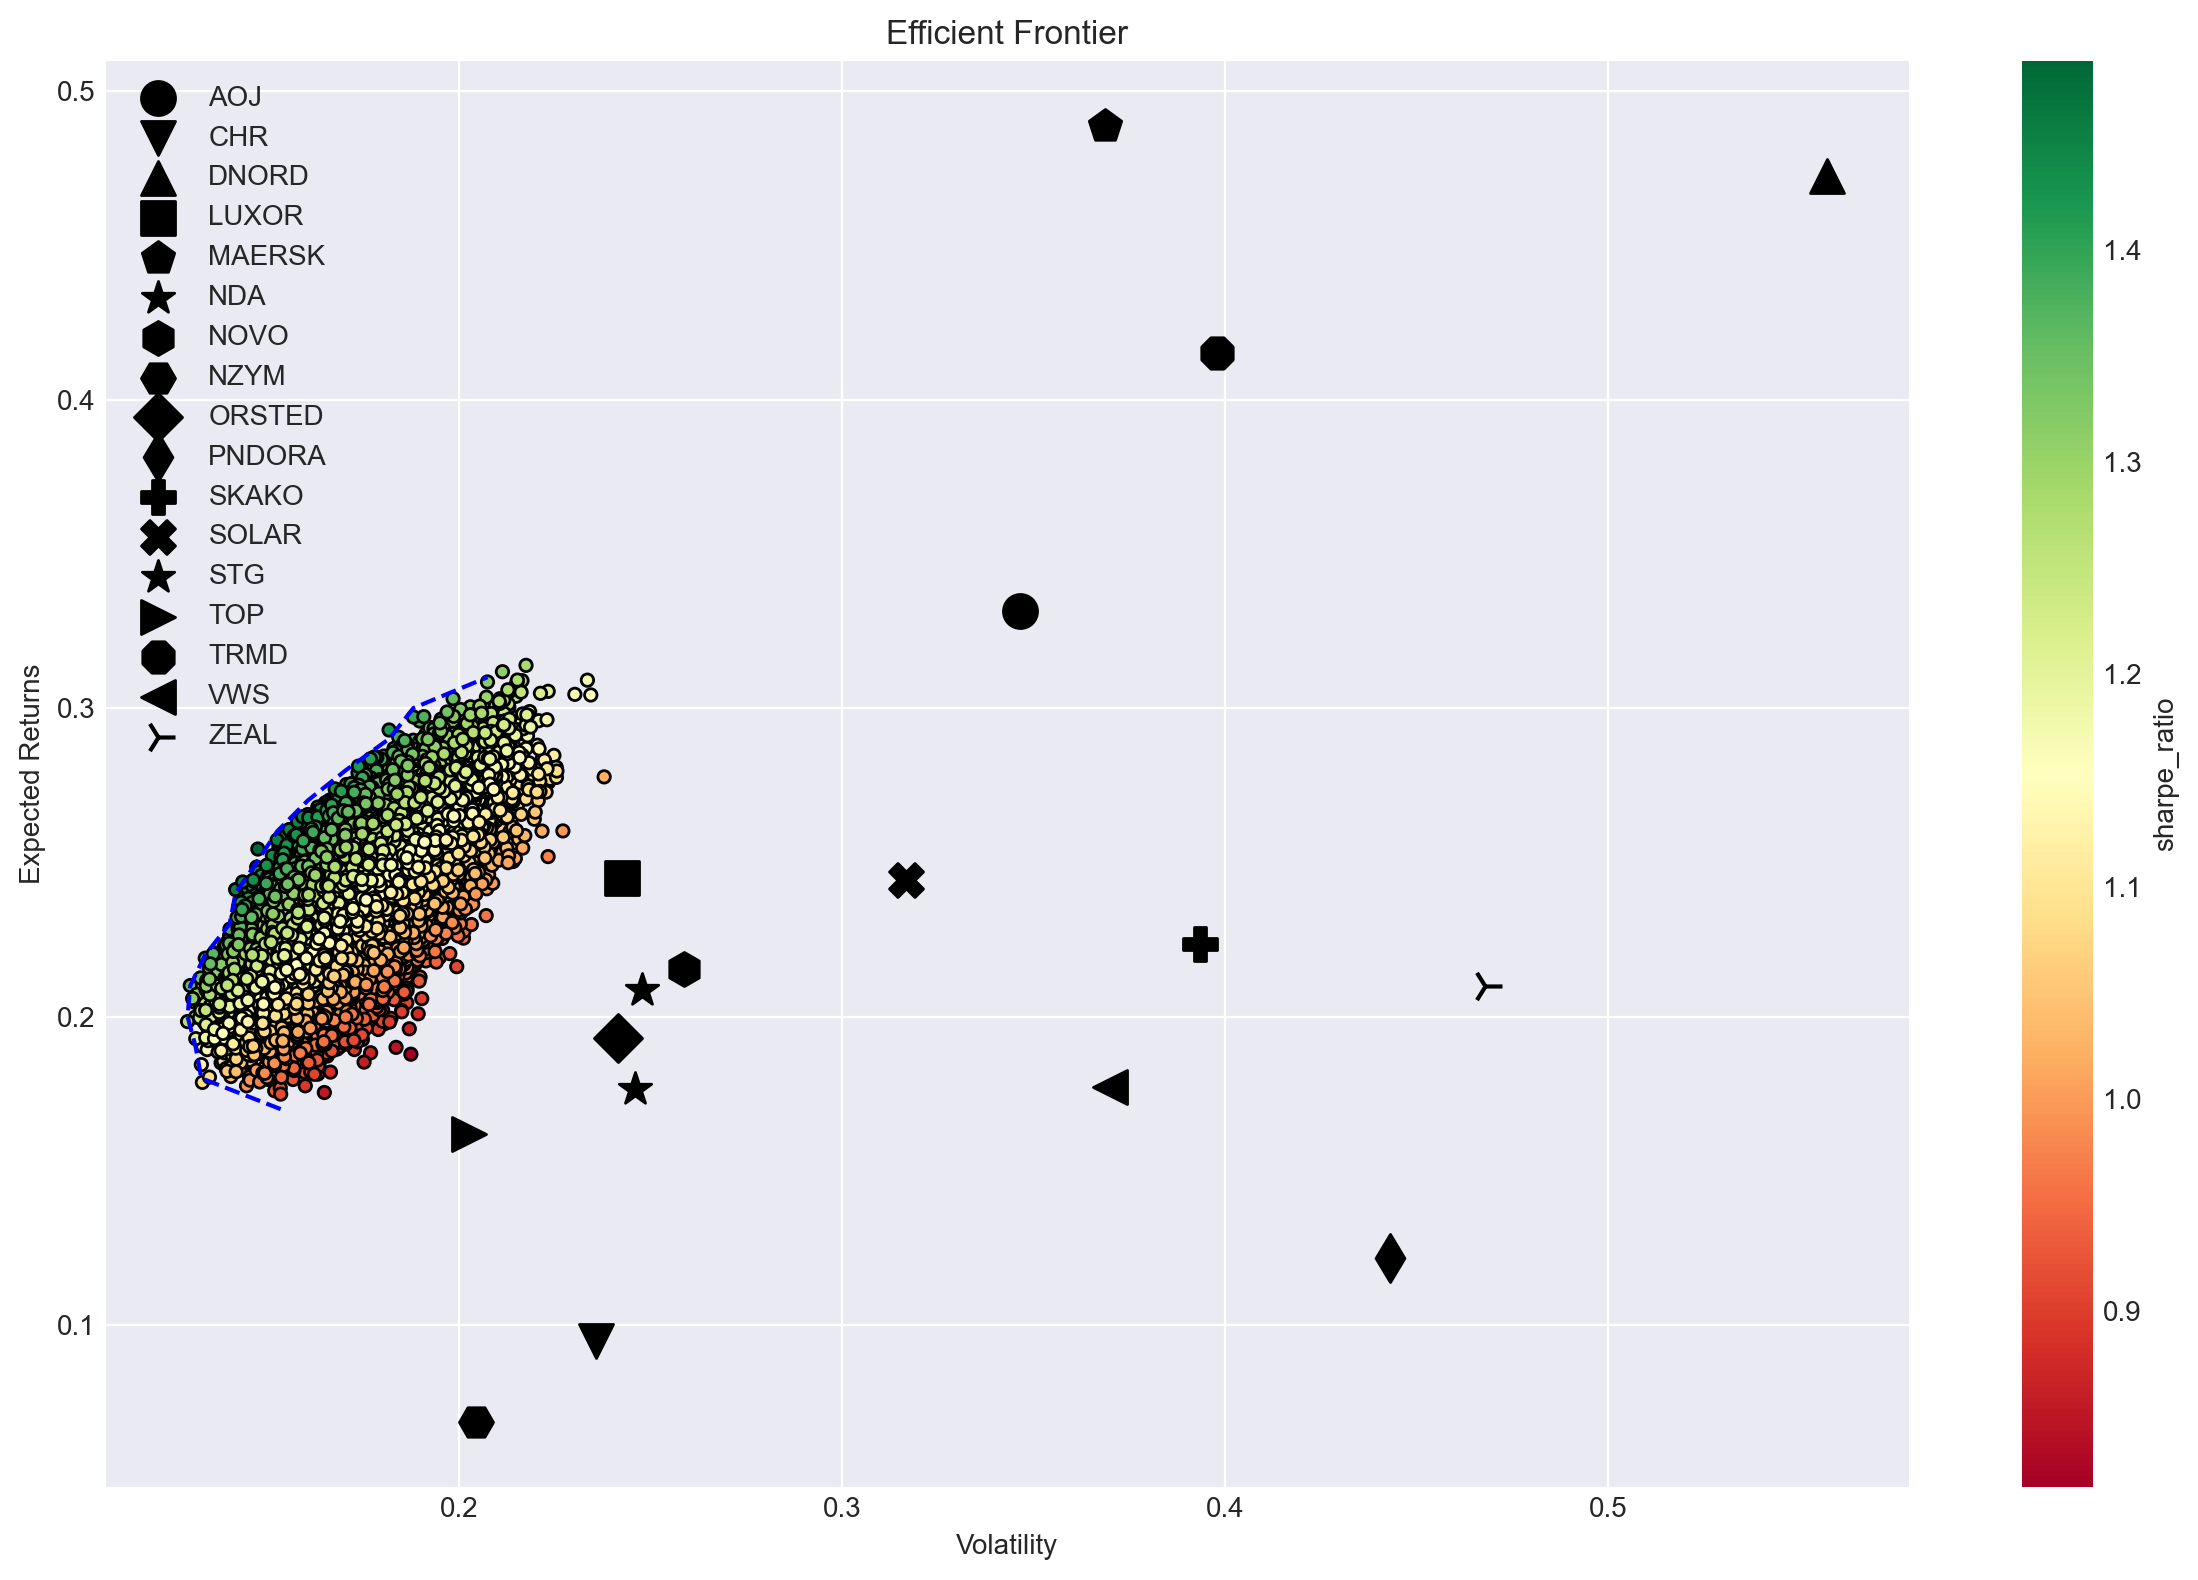

In [16]:
MARKS = ['o', 'v', '^', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '*', 
         '>', '8', '<', '4']

fig, ax = plt.subplots(figsize=(12, 8))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_matrix.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=stocks_names[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

### Max sharpe ratio portfolio

Let's now find the *Maximum Sharpe Ration Portfolio* which is the portfolio with maximum sharpe ratio. This portfolio can be obtained solving the following non linear program:

$$
\begin{align}
\min_{w} & - \frac{\boldsymbol w^T \boldsymbol \mu - r_f}{\sqrt{\boldsymbol w^T C \boldsymbol w}}  &\\
\text{s.t.: } & \sum_{i=1}^N w_i = 1 \\
& w_i \ge 0 & \forall i \in \{1, \cdots, N\}
\end{align}
$$

In [17]:
RF_RATE = danish_2y_yield
args = (avg_returns, cov_matrix, RF_RATE)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
max_sharpe_portf = get_optimal_portfolio(f_obj=neg_sharpe_ratio,
                                        args=args,
                                        constraints=constraints,
                                        bounds=bounds)

In [18]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w,
                                                avg_returns,
                                                cov_matrix),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

In [19]:
rtns_range = np.linspace(-0.22, 0.50, 200)

In [20]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_matrix, 
                                              rtns_range)

In [21]:
vols_range = [x['fun'] for x in efficient_portfolios]

In [22]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': ((min_vol_portf_rtn - danish_2y_yield) / 
                                  min_vol_portf_vol)}

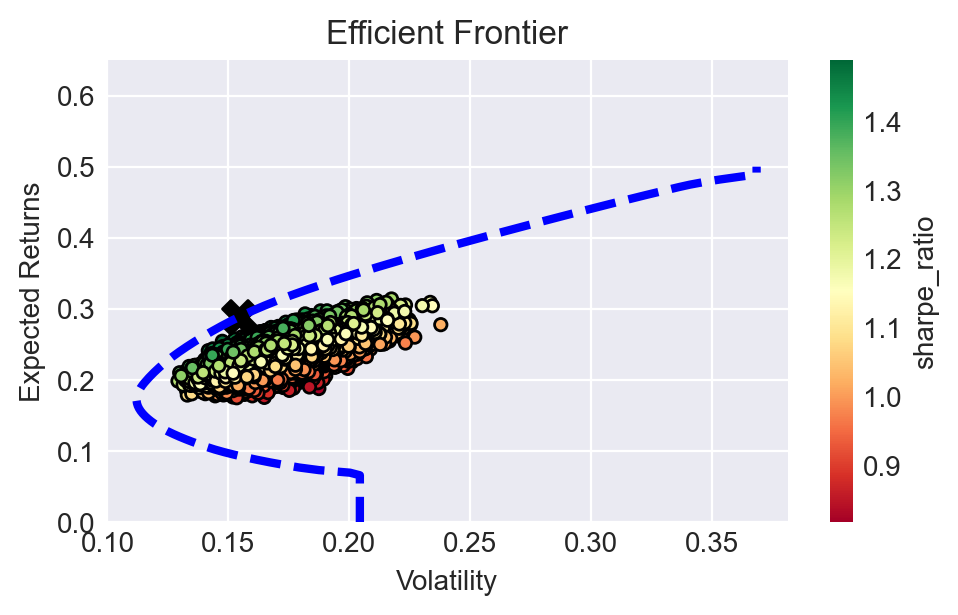

In [23]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')
ax.scatter(x=max_sharpe_portf['Volatility'],
                y=max_sharpe_portf['Return'],
                marker='X',
                s=150,
                color='black',
                label='MSR')

plt.ylim(0.00,0.65)
plt.show()

In [24]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(stocks_names, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 28.84% Volatility: 15.44% Sharpe Ratio: 164.36% 
Weights
AOJ: 7.36% CHR: 0.00% DNORD: 0.00% LUXOR: 25.10% MAERSK: 17.66% NDA: 0.00% NOVO: 12.93% NZYM: 0.00% ORSTED: 16.86% PNDORA: 0.00% SKAKO: 9.84% SOLAR: 0.00% STG: 1.67% TOP: 0.00% TRMD: 6.30% VWS: 0.00% ZEAL: 2.27% 